# Creating plots of CCC and CSC criteria

This notebook provides code to create figures of the CCC and CSC criteria. We consider 4 types of noise: gaussian, rademacher-like, exponential, and uniform.

(This one is kind of a mess, apologies)

In [1]:
import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib


import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib

from matplotlib import rc
import seaborn as sns

sns.set_style('ticks')
sns.set_context('paper', font_scale=2.25)
fig_dict = {
    'figsize':[8.0, 6.0],
}
math_dict = {
    'fontset': 'cm',
}
legend_dict = {
    'fontsize': 20,
    'markerscale': 2.7,
}
savefig_dict = {
    'bbox': 'tight',
    'transparent': 'True',
    'pad_inches': 0.1,
}
axes_dict = {
    'titlesize': '20',
    'titlepad': '5.5',
    'labelsize': '25',
    'labelpad': '7',
    'formatter.use_mathtext' : 'True'
}
lines_dict = {
    'linewidth': 2.7,
}

rc('figure', **fig_dict)
rc('mathtext', **math_dict)
rc('legend', **legend_dict)
rc('savefig', **savefig_dict)
rc('axes', **axes_dict)
rc('lines', **lines_dict)

from matplotlib.font_manager import FontProperties

f_name = '/Users/ruth/Helvetica/helvetica_regular.ttf'
fm.fontManager.addfont(f_name)
font = ft.FT2Font(f_name)

custom_font = FontProperties(fname= f_name)

matplotlib.rcParams['font.sans-serif'].insert(0, font.family_name)
matplotlib.rcParams['font.family'] = font.family_name

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt

import scipy
from scipy import stats
from tqdm.notebook import tqdm
from scipy.integrate import odeint
from scipy.special import erf
from scipy.special import erfc
from matplotlib import colormaps
from matplotlib import cm

# Define functions

In [3]:
## For student-t noise
def sum_pdf(x_values, risk, sigma, df):
    v = np.sqrt(2 * risk)
    gau_pdf = lambda x: np.exp(-0.5 * (x / v)**2) / (v * np.sqrt(2 * np.pi))
    t_pdf = lambda x: tpdf(x, df, scale=sigma)

    # Define a range for the numerical integration
    t_range = np.linspace(-30 * sigma, 30 * sigma, 100)

    # Calculate gau_pdf and t_pdf over the range of t values
    gau_values = gau_pdf(t_range)
    results = []

    for x in x_values:
        t_pdf_values = t_pdf(x - t_range)
        integrand_values = gau_values * t_pdf_values
        result = scipy.integrate.simpson(integrand_values, x = t_range)
        results.append(result)

    return np.array(results)

##### Define H and G for various kinds of noise distributions with Gaussian data

def F(z):
    return scipy.special.erf(z/np.sqrt(2)) - np.sqrt(2 / np.pi) * z * np.exp(-z**2 / 2)

def H_UNC(risk,eta,c):
    return 1

def G_UNC(risk,eta,c):
    return np.ones_like(eta)


def H_STU(risk,scale,df,c):
    # compute P(not clipping) for Gaussian data and student-t (with df degrees freedom) noise
    range = np.linspace(-c,c,200)
    pdf_vals = sum_pdf(range,risk,scale,df)

    return scipy.integrate.simpson(pdf_vals, x = range)

def G_STU(risk,scale,df,c):

    # Define the variance of the sum distribution
    full_var = 2*risk + scale**2 * (df) / (df - 2)

    range = np.linspace(-c,c,200)
    pdf_vals = sum_pdf(range,risk,scale,df)

    integrand = range**2 * pdf_vals
    truncated_var = scipy.integrate.simpson(integrand, x = range)


    # compute P(clipping) = 1 - P(not clipping) = 1 - H_STU
    p_clip = 1 - H_STU(risk,scale,df,c)

    return (truncated_var + c**2 * p_clip) / full_var


def H_ASY(risk, a, b,q, c):
    # Gaussian data with noise
    #
    #   b       wp aq / (a-b)
    #   0       wp 1-q
    #   -a      wp bq / (b-a)

    pa = b*q/(b+a)
    pb = a*q/(a+b)

    V = np.sqrt(2 * risk)
    sqrt2 = np.sqrt(2)

    p_not_clip = pa/2 * (erf((c - a) / V /np.sqrt(2)) + erf((c + a) / V/np.sqrt(2))) + pb/2 * (erf((c + b) / V /np.sqrt(2)) + erf((c - b) / V/np.sqrt(2))) + (1-q) * erf(c/V/np.sqrt(2))

    return p_not_clip



def G_ASY(risk, a, b,q, c):
    # Gaussian data with noise
    #
    #   b       wp aq / (a-b)
    #   0       wp 1-q
    #   -a      wp bq / (b-a)

    pa = b*q/(b+a)
    pb = a*q/(a+b)

    V = np.sqrt(2 * risk)

    var_terms = lambda r,l,u: (np.exp(-(l**2/2)) * (2* r + l))/np.sqrt(2 * np.pi) - (np.exp(-(u**2/2))* (2 * r + u)) / np.sqrt(2 *np.pi) - (1 + r**2)*erf(l/np.sqrt(2))/2 + (1 + r**2)*erf(u/np.sqrt(2)) / 2

    zero_term = V**2 * var_terms(0, -c / V, c / V) * (1-q)
    a_term = V**2 * var_terms(a/V, (-c-a)/V, (c-a)/V) * pa
    b_term = V**2 * var_terms(-b/V, (-c+b)/V, (c+b) / V) * pb

    truncated_var = zero_term + a_term + b_term


    ### This is P(w^2 > c^2)
    p_not_clip = pa/2 * (erf((c - a) / V /np.sqrt(2)) + erf((c + a) / V/np.sqrt(2))) + pb/2 * (erf((c + b) / V /np.sqrt(2)) + erf((c - b) / V/np.sqrt(2))) + (1-q) * erf(c/V/np.sqrt(2))
    p_clip = 1 - p_not_clip

    return  (truncated_var + c**2 * p_clip) / (2*risk + a*b*q)

def H_GAU(risk,eta,c):
    # Gaussian data gaussian noise with var eta**2
    risk = risk + eta**2/2
    return F(c / np.sqrt(2 * risk)) + c* np.exp(-c**2 / 4 / risk) / np.sqrt(3.1415 * risk)

def G_GAU(risk,eta,c):
    # Gaussian data gaussian noise with var eta**2
    varW = 2 * risk + eta**2
    risk = risk + eta**2/2

    return (2 * risk * F(c / np.sqrt(2 * risk)) + c**2 * erfc(c / np.sqrt(4 * risk))) / (varW)

def H_UNI(risk, eta,c):
    # M is parameter in noise  ~ Unif([-M,M])
    # So, solve for M
    M = np.sqrt(3) * eta

    abs_term = np.exp(-(c+M)**2 / 4 / risk)*(np.exp(c*M/risk)-1)*np.sqrt(4*risk/3.14)
    abs_term += (M-c)*erfc((c-M)/np.sqrt(4 * risk)) + (c+M)*erfc((c+M)/np.sqrt(4 * risk))
    abs_term /= 4*M

    abs_term *= 2 # symmetry

    return 1 - abs_term


def G_UNI(risk, eta, c):
    # M is parameter in noise  ~ Unif([-M,M])
    # So, solve for M
    M = np.sqrt(3) * eta

    quad_term = np.exp(-(c+M)**2 / 4 / risk)*np.sqrt(4 * risk / 3.14)*(-c**2 + c*M-M**2-4*risk+np.exp(c*M/risk)*(c**2 + c*M+M**2+4*risk))
    quad_term += (c**3 - M**3 - 6*M*risk) * erf((c-M)/np.sqrt(4*risk)) - (c**3 + M**3 + 6*M*risk)*erf((c+M)/np.sqrt(4 * risk))
    quad_term /= -6*M

    abs_term = np.exp(-(c+M)**2 / 4 / risk)*(np.exp(c*M/risk)-1)*np.sqrt(4*risk/3.14)
    abs_term += (M-c)*erfc((c-M)/np.sqrt(4 * risk)) + (c+M)*erfc((c+M)/np.sqrt(4 * risk))
    abs_term /= 4*M

    abs_term *= 2 # symmetry

    return (quad_term + c**2 * abs_term) / (2*risk + eta**2)

def H_RAD(risk, lam, q, c):
    # Gaussian data with noise
    #
    #   lam with prob q/2
    #   0       wp 1-q
    #   -lam    wp q/2


    V = np.sqrt(2 * risk)

    M_eps = (c - lam) / V
    N_eps = (c + lam) / V
    sqrt2 = np.sqrt(2)

    p_not_clip = (q/2 * (erf(N_eps/np.sqrt(2)) + erf(M_eps/np.sqrt(2))) + (1-q) * erf(c/V/np.sqrt(2)))
    return p_not_clip


def G_RAD(risk, lam, q, c):
    # Gaussian data with noise
    #
    #   lam with prob q/2
    #   0       wp 1-q
    #   -lam    wp q/2

    V = np.sqrt(2 * risk)

    M_eps = (c - lam) / V
    N_eps = (c + lam) / V
    sqrt2 = np.sqrt(2)

    ### This is E[w^2 : w^2 < c^2]
    t1 = q/2 * F(N_eps) * V**2 + q/2 * F(M_eps) * V**2 + (1-q) * F(c/V) * V**2
    t2 = 2*(np.exp(- N_eps**2 / 2)  - np.exp(-M_eps**2/2)) * q * lam / np.sqrt(2 * 3.1415) * V
    t3 = lam**2 * q / 2 * (erf(M_eps / sqrt2) + erf(N_eps/sqrt2))

    T1 = t1 + t2 + t3

    ### This is P(w^2 > c^2)
    T2 = 1 - (q/2 * (erf(N_eps/sqrt2) + erf(M_eps/sqrt2)) + (1-q) * erf(c/V/sqrt2))

    return  (T1 + c**2 * T2) / (2*risk + lam**2 * q)

def H_EXP(risk, eta,c):
    # solve for l
    l = np.sqrt(2) / eta
    sigma = np.sqrt(2 * risk)


    t1 = np.exp(2*c*l) -  erf( (c - l*sigma**2)/sqrt(2)/ sigma ) - np.exp(2*c*l) * erf( (c + l * sigma**2) / sqrt(2)/sigma ) -1

    return (2*erf(c/(sqrt(2) * sigma)) + np.exp(l * (-2 * c + l * sigma**2)/2) * t1) / 2


def G_EXP(risk, eta, c):
    l = np.sqrt(2) / eta
    sigma = np.sqrt(2 * risk)


    # get the quadratic term
    t1 = 2* np.exp(l *(2* c + l *sigma**2) / 2)*(2 - 2 *c* l +  c**2 * l**2)
    t2 = -2* np.exp(l * (-2 * c + l * sigma**2) / 2)*(2 + 2 *c* l + c**2 * l**2)
    t3 = -4* c* np.exp(-(c**2/(2*sigma**2))) * l**2 * sqrt(2/np.pi) * sigma
    t4 = 2 * l**2 * sigma**2
    t5 =  (2 * l**2 * sigma**2 * (erf( sqrt(c**2/sigma**2 / 2))-1) )
    t6 = 2 * (2 + l**2 * sigma**2) * erf(c/(sqrt(2) * sigma))
    t7 = 4 * erf(c/(sqrt(2) * sigma ))

    t8 = - 2 *  np.exp(l * (-2 * c + l * sigma**2) / 2) * (2 + 2 * c * l + c**2 * l**2) * erf((c - l * sigma**2)/(sqrt(2) * sigma))
    t9 = - 2 * np.exp(l * (2* c + l* sigma**2) / 2)* (2 - 2*c*l + c**2*l**2) * erf((c + l * sigma**2)/(sqrt(2) * sigma))
    denom = 8 + 4 * l**2*sigma**2

    quad_term = (t1 + t2 + t3+ t4 + t5 + t6 + t7 + t8 + t9) / denom * (2 /l**2 + sigma**2)

    # and the clipped term
    t1 = np.exp(2*c*l) -  erf( (c - l*sigma**2)/sqrt(2)/ sigma ) - np.exp(2*c*l) * erf( (c + l * sigma**2) / sqrt(2)/sigma ) -1
    p_clip = 1 - (2*erf(c/(sqrt(2) * sigma)) + np.exp(l * (-2 * c + l * sigma**2)/2) * t1) / 2

    return (quad_term + c**2 * p_clip) / (2*risk + eta**2)

# Clipped stability criterion for paired values of clipping threshold and noise level

In [4]:
# [1,6] is a good default
high = 6 #max val of clip/noise to test
low = 1 # min val of clip/noise to test

levels = None # levels for the colorbar

risk = 1
n_points = 1000
cmap = 'plasma'

## Gaussian noise

## Rademacher

## Exponential

## Uniform

# Plots of the clipping comparison criterion

This ratio determines when a clipping schedule can be chosen such that clipping improves SGD.

In [5]:
tpdf = stats.t.pdf

Cs = np.linspace(0.1,15, 100)

risk = 3
eta = 5
q = 0.2

# Solve for lam (noise value) given q. This is for Rademacher-like noise
lam = eta / sqrt(q)

In [6]:
cm_subsection = np.linspace(0, 0.99, len(Cs) + 1)
colors = [ cm.viridis(x) for x in cm_subsection]
colors.reverse()


Hs_GAU = []
Gs_GAU = []

Hs_RAD = []
Gs_RAD = []

Hs_UNI = []
Gs_UNI = []

Hs_EXP = []
Gs_EXP = []
for c in Cs:
    Hs_GAU.append(H_GAU(risk,eta,c))
    Gs_GAU.append(G_GAU(risk,eta,c))

    Hs_RAD.append(H_RAD(risk,lam,q,c))
    Gs_RAD.append(G_RAD(risk,lam,q,c))

    Hs_UNI.append(H_UNI(risk,eta,c))
    Gs_UNI.append(G_UNI(risk,eta,c))

    Hs_EXP.append(H_EXP(risk,eta,c))
    Gs_EXP.append(G_EXP(risk,eta,c))

Hs_GAU, Gs_GAU = np.array(Hs_GAU), np.array(Gs_GAU)
Hs_RAD, Gs_RAD = np.array(Hs_RAD), np.array(Gs_RAD)
Hs_UNI, Gs_UNI = np.array(Hs_UNI), np.array(Gs_UNI)
Hs_EXP, Gs_EXP = np.array(Hs_EXP), np.array(Gs_EXP)

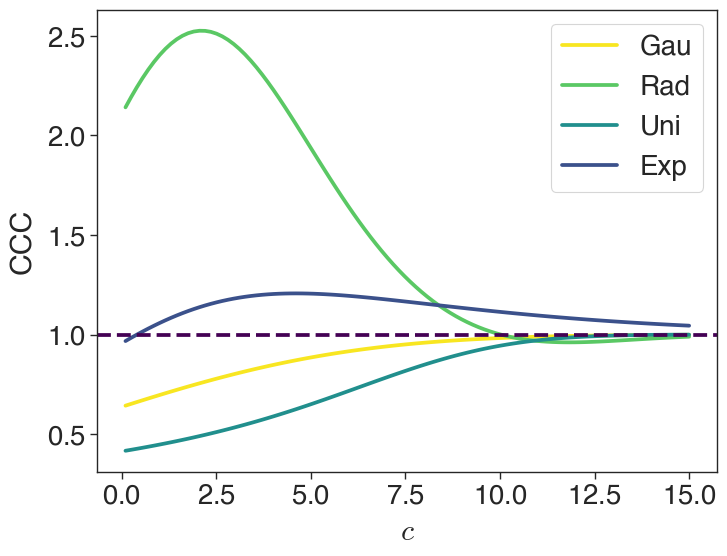

In [7]:
color_GAU = colors[0]
color_RAD = colors[25]
color_UNI = colors[50]
color_EXP = colors[75]

plt.plot(Cs,  Hs_GAU**2 / Gs_GAU , color = color_GAU)
plt.plot(Cs,  Hs_RAD**2 / Gs_RAD , color = color_RAD)
plt.plot(Cs,  Hs_UNI**2 / Gs_UNI , color = color_UNI)
plt.plot(Cs,  Hs_EXP**2 / Gs_EXP , color = color_EXP)
plt.axhline(1, ls= '--', color = colors[-1])
plt.legend(['Gau', 'Rad','Uni','Exp'])
plt.xlabel('$c$', fontproperties=custom_font)
plt.ylabel('CCC', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.savefig('clip_comp_crit_risk3_eta5_q02.pdf', format = 'pdf')
plt.show()

### Plots to compare the student-t thresholds

In [8]:
Cs = np.linspace(0.1,15, 50)

risk = 3
eta = 5

In [9]:
cm_subsection = np.linspace(0, 0.99, len(Cs) + 1)
colors = [ cm.viridis(x) for x in cm_subsection]
colors.reverse()


Gs_df_50 = []
Hs_df_50 = []

Gs_df_10 = []
Hs_df_10 = []

Gs_df_5 = []
Hs_df_5 = []

Gs_df_2_5 = []
Hs_df_2_5 = []

Gs_df_2_1 = []
Hs_df_2_1 = []

for c in tqdm(Cs):
    df = 50
    scale = eta * np.sqrt((df - 2) / df)
    Hs_df_50.append(H_STU(risk,scale,df,c))
    Gs_df_50.append(G_STU(risk,scale,df,c))


    df = 10
    scale = eta * np.sqrt((df - 2) / df)
    Hs_df_10.append(H_STU(risk,scale,df,c))
    Gs_df_10.append(G_STU(risk,scale,df,c))

    df = 5
    scale = eta * np.sqrt((df - 2) / df)
    Hs_df_5.append(H_STU(risk,scale,df,c))
    Gs_df_5.append(G_STU(risk,scale,df,c))

    df = 2.5
    scale = eta * np.sqrt((df - 2) / df)
    Hs_df_2_5.append(H_STU(risk,scale,df,c))
    Gs_df_2_5.append(G_STU(risk,scale,df,c))

    df = 2.1
    scale = eta * np.sqrt((df - 2) / df)
    Hs_df_2_1.append(H_STU(risk,scale,df,c))
    Gs_df_2_1.append(G_STU(risk,scale,df,c))



Hs_df_50, Gs_df_50 = np.array(Hs_df_50), np.array(Gs_df_50)
Hs_df_10, Gs_df_10 = np.array(Hs_df_10), np.array(Gs_df_10)
Hs_df_5, Gs_df_5 = np.array(Hs_df_5), np.array(Gs_df_5)
Hs_df_2_5, Gs_df_2_5 = np.array(Hs_df_2_5), np.array(Gs_df_2_5)
Hs_df_2_1, Gs_df_2_1 = np.array(Hs_df_2_1), np.array(Gs_df_2_1)

  0%|          | 0/50 [00:00<?, ?it/s]

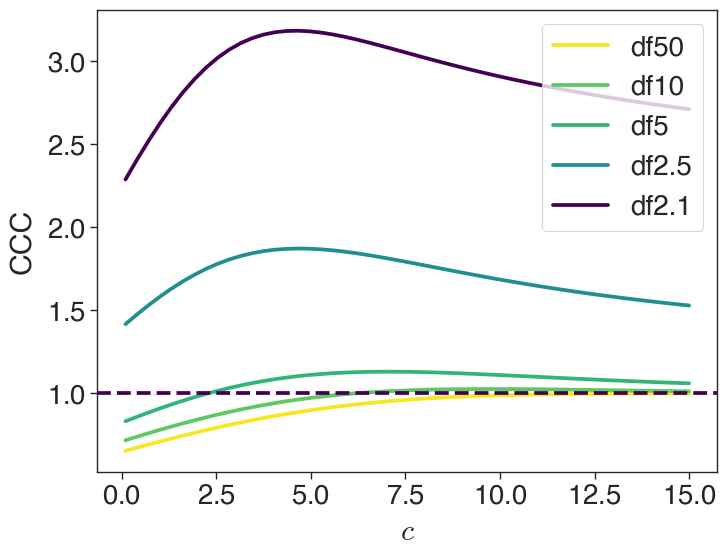

In [10]:
length = len(colors)
color_50 = colors[0]
color_10 = colors[length // 4]
color_5 = colors[length // 3]
color_2_5 = colors[length // 2]
color_2_1 = colors[- 1]

plt.plot(Cs,  Hs_df_50**2 / Gs_df_50 , color = color_50)
plt.plot(Cs,  Hs_df_10**2 / Gs_df_10 , color = color_10)
plt.plot(Cs,  Hs_df_5**2 / Gs_df_5 , color = color_5)
plt.plot(Cs,  Hs_df_2_5**2 / Gs_df_2_5 , color = color_2_5)
plt.plot(Cs,  Hs_df_2_1**2 / Gs_df_2_1 , color = color_2_1)

plt.axhline(1, ls= '--', color = colors[-1])
plt.legend(['df50', 'df10','df5','df2.5', 'df2.1'])
plt.xlabel('$c$', fontproperties=custom_font)
plt.ylabel('CCC', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.savefig('student_t_over_degrees_freedom_ccc.pdf', format = 'pdf')
plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/var/folders/5_/3btrhz8s40584lcy3hwpxz_80000gn/T/ipykernel_59694/3046114902.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu_c$', fontproperties=custom_font)


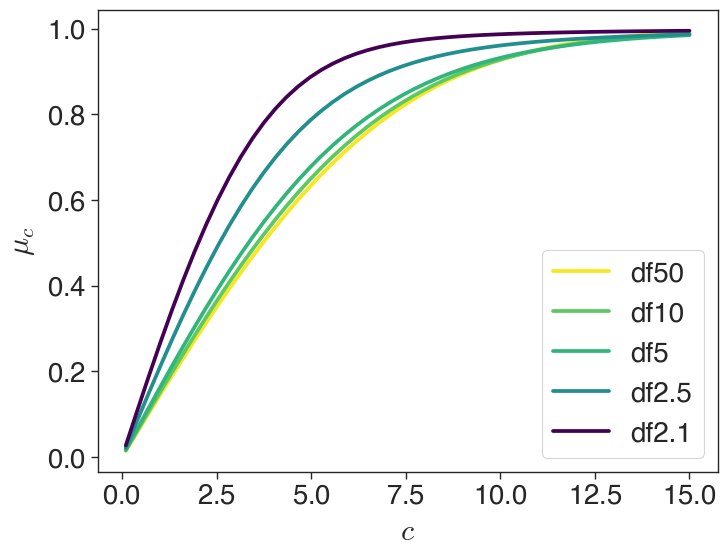

In [11]:
### Plotting mu


length = len(colors)
color_50 = colors[0]
color_10 = colors[length // 4]
color_5 = colors[length // 3]
color_2_5 = colors[length // 2]
color_2_1 = colors[- 1]

plt.plot(Cs,  Hs_df_50 , color = color_50)
plt.plot(Cs,  Hs_df_10 , color = color_10)
plt.plot(Cs,  Hs_df_5 , color = color_5)
plt.plot(Cs,  Hs_df_2_5 , color = color_2_5)
plt.plot(Cs,  Hs_df_2_1 , color = color_2_1)

# plt.axhline(1, ls= '--', color = colors[-1])
plt.legend(['df50', 'df10','df5','df2.5', 'df2.1'])
plt.xlabel('$c$', fontproperties=custom_font)
plt.ylabel('$\mu_c$', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.savefig('student_t_over_degrees_freedom_mu.pdf', format = 'pdf')
plt.show()


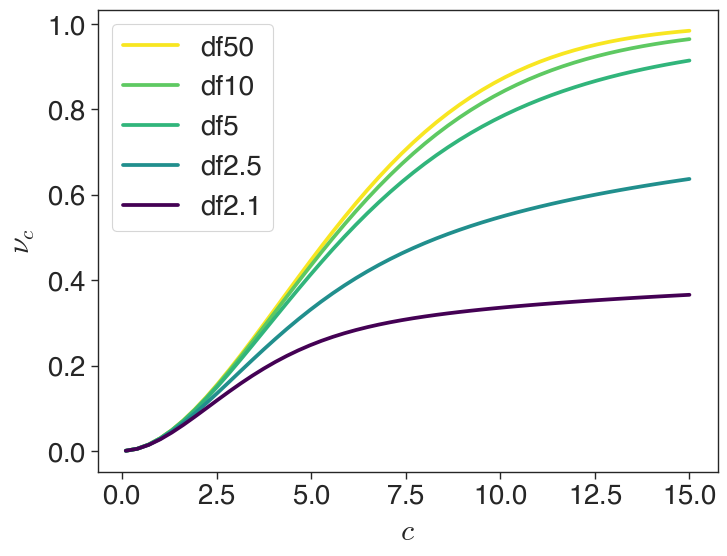

In [12]:
### Plotting nu

length = len(colors)
color_50 = colors[0]
color_10 = colors[length // 4]
color_5 = colors[length // 3]
color_2_5 = colors[length // 2]
color_2_1 = colors[- 1]

plt.plot(Cs,  Gs_df_50 , color = color_50)
plt.plot(Cs,  Gs_df_10 , color = color_10)
plt.plot(Cs,  Gs_df_5 , color = color_5)
plt.plot(Cs,  Gs_df_2_5 , color = color_2_5)
plt.plot(Cs,  Gs_df_2_1 , color = color_2_1)


# plt.axhline(1, ls= '--', color = colors[-1])
plt.legend(['df50', 'df10','df5','df2.5', 'df2.1'])
plt.xlabel('$c$', fontproperties=custom_font)
plt.ylabel('$\\nu_c$', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.savefig('student_t_over_degrees_freedom_nu.pdf', format = 'pdf')
plt.show()

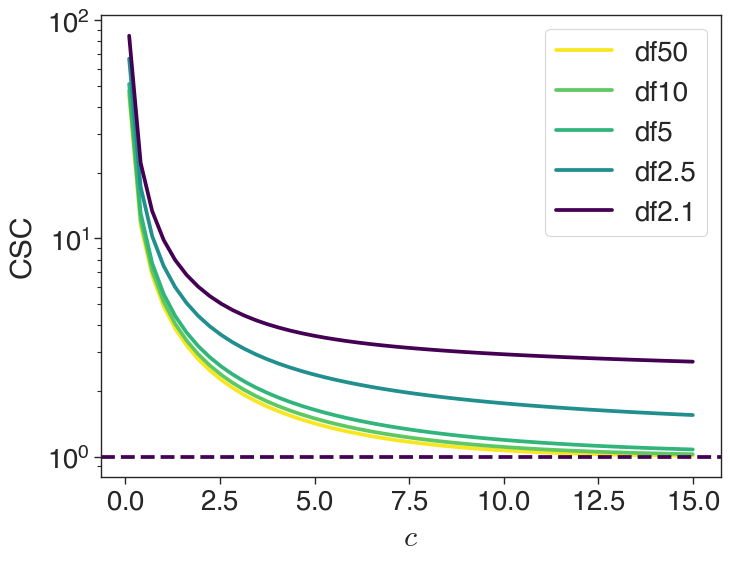

In [13]:
length = len(colors)
color_50 = colors[0]
color_10 = colors[length // 4]
color_5 = colors[length // 3]
color_2_5 = colors[length // 2]
color_2_1 = colors[- 1]

plt.semilogy(Cs,  Hs_df_50 / Gs_df_50 , color = color_50)
plt.semilogy(Cs,  Hs_df_10 / Gs_df_10 , color = color_10)
plt.semilogy(Cs,  Hs_df_5 / Gs_df_5 , color = color_5)
plt.semilogy(Cs,  Hs_df_2_5 / Gs_df_2_5 , color = color_2_5)
plt.semilogy(Cs,  Hs_df_2_1 / Gs_df_2_1 , color = color_2_1)

plt.axhline(1, ls= '--', color = colors[-1])
plt.legend(['df50', 'df10','df5','df2.5', 'df2.1'])
plt.xlabel('$c$', fontproperties=custom_font)
plt.ylabel('CSC', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.savefig('student_t_over_degrees_freedom_csc.pdf', format = 'pdf')
plt.show()

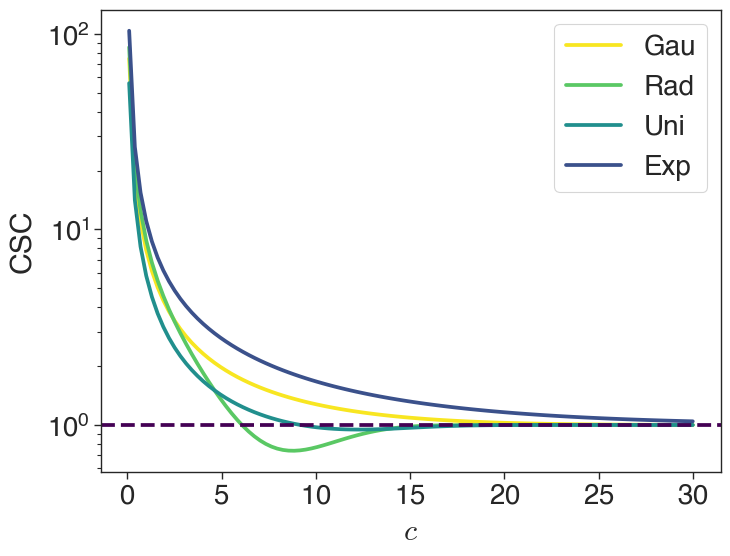

In [14]:
Cs = np.linspace(0.1,30, 100)

risk = 3
eta = 9
q = 0.7

# Solve for lam (noise value) given q. This is for Rademacher-like noise
lam = eta / sqrt(q)

cm_subsection = np.linspace(0, 0.99, len(Cs) + 1)
colors = [ cm.viridis(x) for x in cm_subsection]
colors.reverse()


Hs_GAU = []
Gs_GAU = []

Hs_RAD = []
Gs_RAD = []

Hs_UNI = []
Gs_UNI = []

Hs_EXP = []
Gs_EXP = []
for c in Cs:
    Hs_GAU.append(H_GAU(risk,eta,c))
    Gs_GAU.append(G_GAU(risk,eta,c))

    Hs_RAD.append(H_RAD(risk,lam,q,c))
    Gs_RAD.append(G_RAD(risk,lam,q,c))

    Hs_UNI.append(H_UNI(risk,eta,c))
    Gs_UNI.append(G_UNI(risk,eta,c))

    Hs_EXP.append(H_EXP(risk,eta,c))
    Gs_EXP.append(G_EXP(risk,eta,c))

Hs_GAU, Gs_GAU = np.array(Hs_GAU), np.array(Gs_GAU)
Hs_RAD, Gs_RAD = np.array(Hs_RAD), np.array(Gs_RAD)
Hs_UNI, Gs_UNI = np.array(Hs_UNI), np.array(Gs_UNI)
Hs_EXP, Gs_EXP = np.array(Hs_EXP), np.array(Gs_EXP)


plt.semilogy(Cs,  Hs_GAU / Gs_GAU , color = color_GAU)
plt.semilogy(Cs,  Hs_RAD / Gs_RAD , color = color_RAD)
plt.semilogy(Cs,  Hs_UNI / Gs_UNI , color = color_UNI)
plt.semilogy(Cs,  Hs_EXP / Gs_EXP , color = color_EXP)
plt.axhline(1, ls= '--', color = colors[-1])
plt.legend(['Gau', 'Rad','Uni','Exp'])
plt.xlabel('$c$', fontproperties=custom_font)
plt.ylabel('CSC', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.savefig('clip_stab_crit_risk3_eta9_q07.pdf', format = 'pdf')
plt.show()

# Plotting the maximum of CCC and CSC as a function of the risk

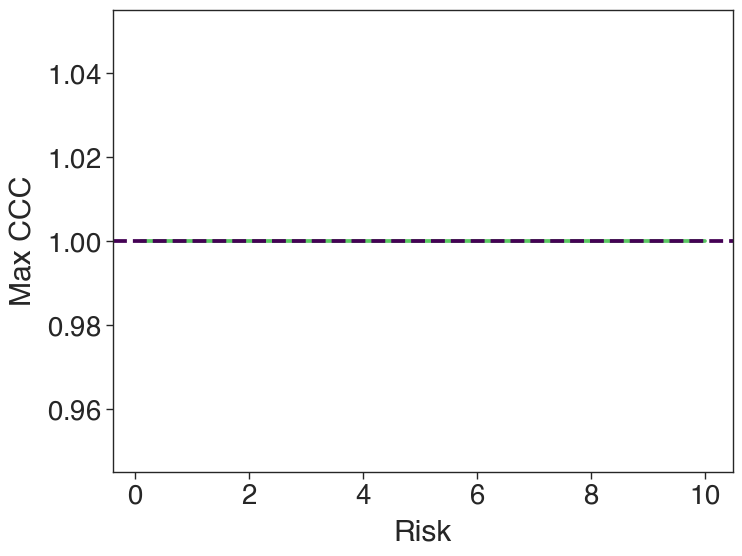

In [15]:
risk = 5
eta = 5
q = 0.9


# Solve for lam (noise value) given q. This is for Rademacher-like noise
lam = eta / sqrt(q)

n = 30
Cs = np.linspace(0.1,20, n)
Rs = np.linspace(0.1,10, n)

maxCCC_RAD = []
for risk in Rs:
    CCC_RAD = []
    for c in Cs:
        CCC_RAD.append(H_RAD(risk,lam, q,c)**2 / G_RAD(risk,lam, q,c))
    argmax_r = np.argmax(CCC_RAD)
    maxCCC_RAD.append(CCC_RAD[argmax_r])

maxCCC_RAD = np.maximum(np.array(maxCCC_RAD), 1)

plt.plot(Rs,  maxCCC_RAD, color = color_RAD)
plt.axhline(1, ls= '--', color = colors[-1])

plt.xlabel('Risk', fontproperties=custom_font)
plt.ylabel('Max CCC', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.show()

In [16]:
eta = 7
q = 0.5

# Solve for lam (noise value) given q. This is for Rademacher-like noise
lam = eta / sqrt(q)

n = 100
Cs = np.linspace(0.1,20, n)
Rs = np.linspace(0.1,10, n)


maxCCC_Gau = []
maxCCC_RAD = []
maxCCC_EXP = []
maxCCC_UNI = []

maxCSC_Gau = []
maxCSC_RAD = []
maxCSC_EXP = []
maxCSC_UNI = []


for risk in Rs:
    CSC_Gau = []
    CSC_RAD = []
    CSC_EXP = []
    CSC_UNI = []

    CCC_Gau = []
    CCC_RAD = []
    CCC_EXP = []
    CCC_UNI = []
    for c in Cs:
        CSC_Gau.append(H_GAU(risk,eta,c) / G_GAU(risk,eta,c))
        CSC_RAD.append(H_RAD(risk,lam, q,c) / G_RAD(risk,lam, q,c))
        CSC_EXP.append(H_EXP(risk,eta,c) / G_EXP(risk,eta,c))
        CSC_UNI.append(H_UNI(risk,eta,c) / G_UNI(risk,eta,c))

        CCC_Gau.append(H_GAU(risk,eta,c)**2 / G_GAU(risk,eta,c))
        CCC_RAD.append(H_RAD(risk,lam, q,c)**2 / G_RAD(risk,lam, q,c))
        CCC_EXP.append(H_EXP(risk,eta,c)**2 / G_EXP(risk,eta,c))
        CCC_UNI.append(H_UNI(risk,eta,c)**2 / G_UNI(risk,eta,c))


    argmax_g = np.argmax(CCC_Gau)
    argmax_r = np.argmax(CCC_RAD)
    argmax_e = np.argmax(CCC_EXP)
    argmax_u = np.argmax(CCC_UNI)

    maxCCC_Gau.append(CCC_Gau[argmax_g])
    maxCCC_RAD.append(CCC_RAD[argmax_r])
    maxCCC_EXP.append(CCC_EXP[argmax_e])
    maxCCC_UNI.append(CCC_UNI[argmax_u])

    maxCSC_Gau.append(CSC_Gau[argmax_g])
    maxCSC_RAD.append(CSC_RAD[argmax_r])
    maxCSC_EXP.append(CSC_EXP[argmax_e])
    maxCSC_UNI.append(CSC_UNI[argmax_u])

maxCCC_Gau = np.maximum(np.array(maxCCC_Gau), 1)
maxCCC_RAD = np.maximum(np.array(maxCCC_RAD), 1)
maxCCC_EXP = np.maximum(np.array(maxCCC_EXP), 1)
maxCCC_UNI = np.maximum(np.array(maxCCC_UNI), 1)

/var/folders/5_/3btrhz8s40584lcy3hwpxz_80000gn/T/ipykernel_59694/909816540.py:122: RuntimeWarning: overflow encountered in exp
  abs_term = np.exp(-(c+M)**2 / 4 / risk)*(np.exp(c*M/risk)-1)*np.sqrt(4*risk/3.14)
/var/folders/5_/3btrhz8s40584lcy3hwpxz_80000gn/T/ipykernel_59694/909816540.py:122: RuntimeWarning: invalid value encountered in scalar multiply
  abs_term = np.exp(-(c+M)**2 / 4 / risk)*(np.exp(c*M/risk)-1)*np.sqrt(4*risk/3.14)
/var/folders/5_/3btrhz8s40584lcy3hwpxz_80000gn/T/ipykernel_59694/909816540.py:136: RuntimeWarning: overflow encountered in exp
  quad_term = np.exp(-(c+M)**2 / 4 / risk)*np.sqrt(4 * risk / 3.14)*(-c**2 + c*M-M**2-4*risk+np.exp(c*M/risk)*(c**2 + c*M+M**2+4*risk))
/var/folders/5_/3btrhz8s40584lcy3hwpxz_80000gn/T/ipykernel_59694/909816540.py:136: RuntimeWarning: invalid value encountered in scalar multiply
  quad_term = np.exp(-(c+M)**2 / 4 / risk)*np.sqrt(4 * risk / 3.14)*(-c**2 + c*M-M**2-4*risk+np.exp(c*M/risk)*(c**2 + c*M+M**2+4*risk))
/var/folders/5_/3b

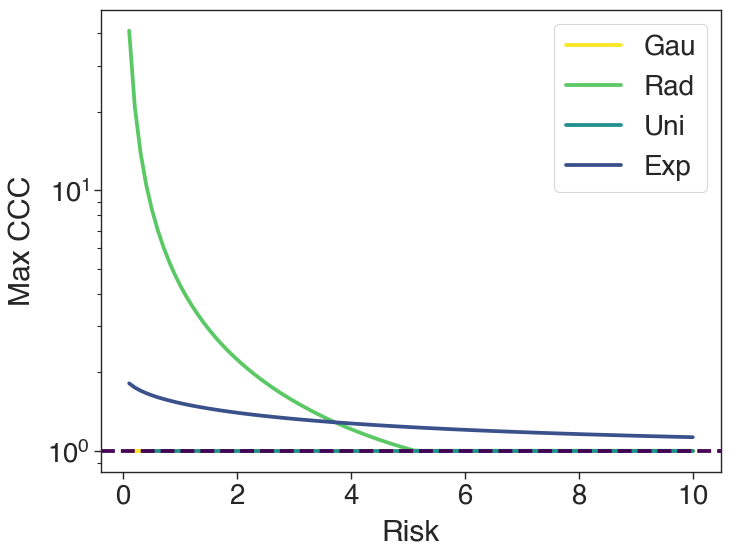

In [17]:
plt.semilogy(Rs,  maxCCC_Gau, color = color_GAU)
plt.semilogy(Rs,  maxCCC_RAD, color = color_RAD)
plt.semilogy(Rs,  maxCCC_UNI, color = color_UNI)
plt.semilogy(Rs,  maxCCC_EXP, color = color_EXP)
plt.axhline(1, ls= '--', color = colors[-1])

plt.legend(['Gau', 'Rad', 'Uni', 'Exp'])
plt.xlabel('Risk', fontproperties=custom_font)
plt.ylabel('Max CCC', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.savefig('max_ccc_eta7_q05.pdf', format = 'pdf')
plt.show()

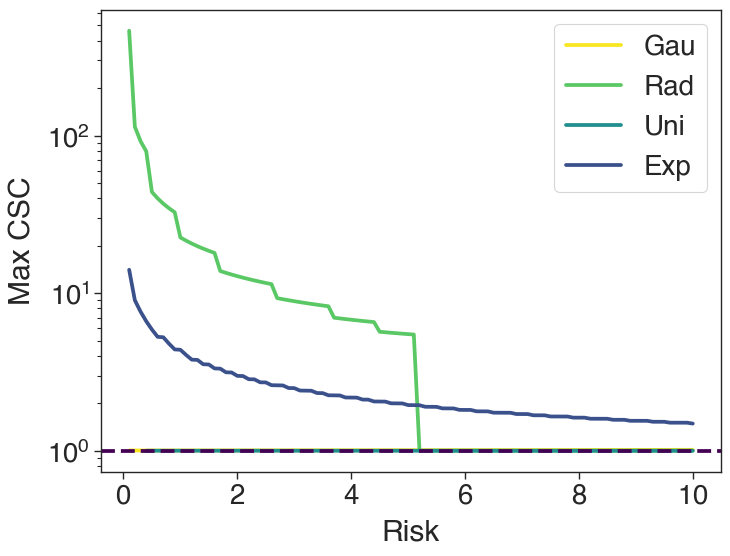

In [19]:
plt.semilogy(Rs,  maxCSC_Gau, color = color_GAU)
plt.semilogy(Rs,  maxCSC_RAD, color = color_RAD)
plt.semilogy(Rs,  maxCSC_UNI, color = color_UNI)
plt.semilogy(Rs,  maxCSC_EXP, color = color_EXP)
plt.axhline(1, ls= '--', color = colors[-1])

plt.legend(['Gau', 'Rad', 'Uni', 'Exp'])
plt.xlabel('Risk', fontproperties=custom_font)
plt.ylabel('Max CSC', fontproperties=custom_font)
# plt.xlabel('clip threshold')
plt.show()